# **1. Initialization - Import / Install libraries**


In [1]:
# This is a magic function to generate the graph within the notebook 
%matplotlib inline

# Install library 
!pip install nltk
!pip install pymysql
!pip install pyLDAvis

In [2]:
# Here is a list of libraries we need to conduct the analysis:
import pandas as pd                                           # Loading files into pandas dataframe
import numpy as np                                            # To use numpy aggregation functions
from tqdm.auto import tqdm                                    # track loop time
import warnings                                               # Suppress all warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pickle
import pymysql
import re
import json
import model_shared_utilities as msu                          # helper functions 
import topic_model_utilities as tm                            # helper functions
# --------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt                               # Generate visualization 
import matplotlib.cm as cm
import altair as alt                                          
import seaborn as sns
import pyLDAvis.sklearn
# --------------------------------------------------------------------------------------------------
from sklearn.preprocessing import StandardScaler              # Transforming dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from nltk.tokenize import sent_tokenize
# --------------------------------------------------------------------------------------------------
from sklearn.decomposition import NMF, LatentDirichletAllocation    # Model Training
# --------------------------------------------------------------------------------------------------
from sklearn.metrics.pairwise import cosine_similarity        # Calculate the similarity between word vectors
# --------------------------------------------------------------------------------------------------
import nltk                                                   # Downloading necessary packagings from nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\laiya\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\laiya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laiya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\laiya\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\laiya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laiya\AppData\Roaming\nltk_data...
[nltk

True

In [3]:
# use this to set random_state to reproduce the same result
RANDOM_SEED = 14


# **2. Helper Functions**

Functions in the ***topic_model_utilities*** module:

 1. train_model(vec_docs, n_topics, model_type):
  * Train LDA/NMF model
 2. get_top_terms(model, terms, no_top_words, display=False):
  * extract the top n terms for each topic
 3. topical_coherence(words_list, embeddings_dict):
  * calculate the cosine similarity of the words in the list using a pretrained word embeddings
 4. eval_topic_model(model, vec_docs, top_terms, embeddings_dict, display=True):
  * evaluate the topic model based on the average topical coherence score 

# **3. Load / Transform Data**

In [4]:
# read the secret keys from json file 
# Note the config file need to be filled with your own credentials before running this notebook 
# or ask the owners of this repository for the filled config file
with open('config.json', 'r') as f:
    secret = json.load(f)

In [5]:
# connect to the database
connection = pymysql.connect(host=secret['host'],
                              user=secret['user'],
                              password=secret['password'],
                              database=secret['database'],
                              port=secret['port'],
                              charset=secret['charset'],
                              cursorclass=pymysql.cursors.DictCursor)

cursor = connection.cursor()

cursor.execute("SELECT * FROM jd;")
table = cursor.fetchall()
connection.close()

In [6]:
# Now let's put the table into pandas dataframe 
job_df = pd.DataFrame(table)
job_df = job_df.dropna(subset=['job_description'])
print("Job dataset has", job_df.shape[0], "rows of data")


Job dataset has 18087 rows of data


In [7]:
# remove words that are common in job postings and data science related terms
stopwords = ["job", "summary", "posted", "location" , "employee", "today", "type", "data", "scientist", "level", "experience", "skills", 
             "deep", "learning", "machine", "jobdescriptiontext", "ability", "analytics", "work", "modeling", "models", "analysis", "research", 
             "big", "technical", "requirements", "requirement", "required", "strong", "years", "team", "experienced",
             "rsquo", "nbsp", "reference", "career", "persons", "hired", "eligibility", "applicants", "authorized", "transform",
             "manipulate", "need", "position", "complete", "employment", "document", "verify", "identity", "looking", "equal", "apply", "status",
             "color", "veteran", "religion", "race", "origin", "sexual", "orientation", "opportunity", "disability", "gender", "time", "recruitment", "hiring", 
             "people", "working", "employer", "qualified", "form", "hire", "pregnancy", "marital", "color", "compliance", "federal", "right", "resume", "protected", "applicable", "laws",
             "statistical", "projects", "provide", "reports", "including" , "large", "engineering", "insights" , "computer", "problems",
             "algorithms", "knowledge", "advanced", "statistics", "solutions", "using", "techniques", "statistical", "verification", 
             'build', 'help', 'products', 'teams', 'company', 'building', 'make', 'full', 'please', 'paid', 'jefferson', 'frank', 'cybercoders',    
             'python', 'spark', 'sets', 'mining', 'customers', 'services', 'related', 'degree', 'support', 'information', 'project', 
             'related', 'must','scientists', 'processing', 'language', 'engineers', 'applied',
             'reporting', 'processes', 'analyst', 'customer', 'needs', 'booz', 'allen', 'robert', 'half', 'change', 'answers', 'certifications', 'turn', 'taboola', 'newsroom', 
             'paid', 'preferred', 'schedule', 'benefits', 'year', 'dental', 'vision', 'clearance', 'jobs', 'find', 'organizations', 'jeffersonfrank', 'north', 'america',
             'forward', 'receiving', 'states', 'upon', 'characteristic', 'united', 'national', 'proud', 'receive', 'click', 'consideration', 'without', 'regard',
             'capture', 'methods', 'structured', 'unstructured', 'outcomes', 'analyses', 'read', 'something'
             'drive', 'complex', 'results', 'across', 'sources', 'identify', 'great', 'happy', 'qualifications', 'relevant', 'application', 'essential',
             'field', 'best','perform', 'relevant', 'duties', 'drive', 'analytic', 'role', 'responsibilities', 'join', 'impact', 'science', 'analytical', 'develop', 'quantitative',
             'scale', 'like','opportunities','understanding', 'training', 'access', 'intelligence', 'know', 'world', 'onsite', 'responsibilitie', 'cluster', 
             'four', 'greater', 'case', 'problem', 'interpreting', 'feature', 'carlo', 'bagging', 'professionals', 'deploy', 'nosql', 'interpreting'] 
my_stop_words = set(nltk.corpus.stopwords.words('english')).union(stopwords)

In [8]:
# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000,              # only top n by freq
                                   lowercase=True,                  # keep caps
                                   token_pattern=r"[A-Za-z]{4,15}", # words with 4 to 15 characters
                                   ngram_range=(1,2),               # include 2-word phrases
                                   min_df=25,                       # note: absolute count of doc
                                   max_df=0.75,                     # note: % of docs
                                   stop_words=my_stop_words)            # default English stopword
                                   
# Count Vectorizer
tf_vectorizer = CountVectorizer(max_features=10000,              # only top n by freq
                                lowercase=True,                  # keep caps
                                token_pattern=r"[A-Za-z]{4,15}", # words with 4 to 15 characters
                                ngram_range=(1,2),               # include 2-word phrases
                                min_df=25,                       # note: absolute count of doc
                                max_df=0.75,                     # note: % of docs
                                stop_words=my_stop_words)            # default English stopword

In [9]:
# transforming the data
tfidf_docs = tfidf_vectorizer.fit_transform(job_df["cleaned_jd"])  
print(tfidf_docs.shape)
tfidf_terms = tfidf_vectorizer.get_feature_names()

tf_docs = tf_vectorizer.fit_transform(job_df["cleaned_jd"])  
print(tf_docs.shape)
tf_terms = tf_vectorizer.get_feature_names()

(18087, 10000)
(18087, 10000)


In [22]:
# BEFORE RUNNING THIS - please download the file from the link below 
# pretrained word vectors from https://nlp.stanford.edu/projects/glove/

# Load the pretrained word embedding to embeddings_dict
# Note: file path will different depend on where you saved the pretrained embeddings
file_path = 'C:/Users/laiya/Desktop/MADS/capstones/glove.42B.300d/'
embedding_filename = 'glove.42B.300d.txt'
embeddings_dict = {}
with open(file_path+embedding_filename, 'r', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

# **4. Model Training**

In this section, we will be training two types of topic model - Non-Negative Matrix Factorization and Latent Dirichlet Allocation. We will be evaluating the model performance using two measures: 
* **Topic coherence**: Using a pretrained word vectors from [GloVe](https://nlp.stanford.edu/projects/glove/) to transform the top terms into word vectors and then compute their pairwise cosine similarity (this will create a terms x terms matrix) and finally take the mean over all pairwise distances as the topic coherence score for that specific topic (we will repeat this step for each topic and the final coherence score for the model will be based on the mean of all the topic coherence scores)


## 4.A. Non-Negative Matrix Factorization

In this section, we will be generating a set of topics and a set of top terms for each topic using [NMF](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html). Similar to principal component analysis (PCA), Non-negative Matrix Factorization factors high-dimensional vectors into a low-dimensionality representation, however, NMF only allow non-negative vectors. NMF can be used for very effective topic modeling, and it's also a reasonably efficient algorithm so the code below run relatively quick in comparison to LDA model. (note: In comparing to the LDA model, NMF model has a lower coherence score for first level of topics so we will not be training NMF model to get the second level of Topics.) 

### 4.A.1. First Level of Topics

  0%|          | 0/18 [00:00<?, ?it/s]

Text(0.5, 0, 'number of clusters')

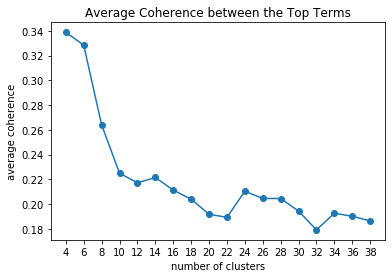

In [24]:
# first let's look at the coherence score based different number of topics 
topics = range(4,40,2)
coh_scores = []
for t in tqdm(topics): 
    model = tm.train_model(tfidf_docs, t, 'NMF', RANDOM_SEED)
    top_terms = tm.get_top_terms(model, tfidf_terms, 10, display=False)
    mean_coherence, _ = tm.eval_topic_model(top_terms, embeddings_dict, display=False)
    coh_scores.append(mean_coherence)

# let's create a simple line plot 
fig, ax = plt.subplots()
ax.plot(topics, coh_scores, marker='o')
ax.set_xticks(topics)
ax.set_xticklabels(topics)
plt.title('Average Coherence between the Top Terms')
plt.ylabel('average coherence')
plt.xlabel('number of clusters')

In [ ]:
# let's look at the top terms from the cluster with the highest coherence score according to the plot above
model = tm.train_model(tfidf_docs, 4, 'NMF', RANDOM_SEED)
top_terms = tm.get_top_terms(model, tfidf_terms, 15, display=True)
mean_coherence, _ = tm.eval_topic_model(model, tfidf_docs, top_terms, embeddings_dict, display=True)

topic 0: ['business', 'management', 'predictive', 'marketing', 'tools', 'financial', 'product', 'clients', 'stakeholders', 'decision', 'model', 'visualization', 'operations', 'partners', 'technology']
topic 1: ['software', 'development', 'cloud', 'design', 'systems', 'technologies', 'engineer', 'technology', 'code', 'applications', 'platform', 'java', 'azure', 'architecture', 'product']
topic 2: ['insurance', 'health', 'clinical', 'care', 'education', 'management', 'healthcare', 'program', 'equipment', 'system', 'systems', 'medical', 'quality', 'life', 'service']
topic 3: ['security', 'online', 'tools', 'public sectors', 'relationships network', 'network give', 'give helpful', 'university online', 'experts pursuing', 'advantage tuition', 'want chart', 'course success', 'helpful tips', 'certification academic', 'programs vendor']
Overall Topics Coherence score: 0.3295
Number of words not in pretrained word vector: 12


In [ ]:
# For a given document (row) in W which topics (column) the document belongs the most (if the value is high, the document is highly related to the topic).
W = model.transform(tfidf_docs)
job_df['NMF_cluster'] = [np.argmax(i) for i in W]

## 4.B. Latent Dirichlet Allocation

In addition to NMF, we will also be generating a set of topics and top terms for each topic using [LDA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html). Latent Dirichlet Allocation is a probabilistic model, where each topic is modeled as a distribution over words and each document is modeled as a mixture of topics. These probabilities are calculated based on an initial random assignment, and then repeated until it convergences. In comparing to NMF, LDA takes much longer to run.  

### 4.B.1. First Level of Topics

  0%|          | 0/8 [00:00<?, ?it/s]

Text(0.5, 0, 'number of clusters')

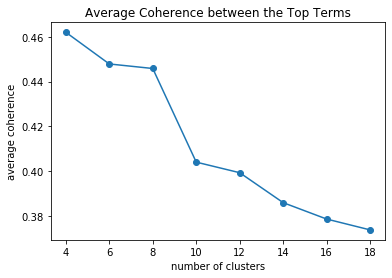

In [25]:
# first let's look at the coherence score based different number of topics 
topics = range(4,20,2)
coh_scores = []
for t in tqdm(topics): 
  model = tm.train_model(tf_docs, t, 'LDA',RANDOM_SEED)
  top_terms = tm.get_top_terms(model, tf_terms, 10, display=False)
  mean_coherence, _ = tm.eval_topic_model(top_terms, embeddings_dict, display=False)
  coh_scores.append(mean_coherence)

# let's create a simple line plot 
fig, ax = plt.subplots()
ax.plot(topics, coh_scores, marker='o')
ax.set_xticks(topics)
ax.set_xticklabels(topics)
plt.title('Average Coherence between the Top Terms')
plt.ylabel('average coherence')
plt.xlabel('number of clusters')

In [26]:
# let's look at the top terms from the cluster with the highest coherence score according to the plot above
model = tm.train_model(tf_docs, 4, 'LDA', RANDOM_SEED)
top_terms = tm.get_top_terms(model, tf_terms, 10, display=True)
mean_coherence, _ = tm.eval_topic_model(top_terms, embeddings_dict, display=True)

topic 0: ['software', 'development', 'systems', 'design', 'insurance', 'environment', 'engineer', 'management', 'system', 'health']
topic 1: ['business', 'management', 'tools', 'development', 'product', 'design', 'systems', 'technology', 'performance', 'process']
topic 2: ['security', 'education', 'employees', 'mission', 'program', 'technology', 'product', 'based', 'candidates', 'service']
topic 3: ['business', 'clients', 'technology', 'tools', 'development', 'financial', 'global', 'management', 'client', 'environment']
Overall Topics Coherence score: 0.4620
Number of words not in pretrained word vector: 0


In [28]:
# This is a interactive visualization
warnings.filterwarnings("ignore", category=DeprecationWarning) 
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(model, tf_docs, tf_vectorizer, mds='tsne', sort_topics=False)
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      269.562408 -124.803398       1        1  26.833656
1        1.782994 -295.079681       2        1  40.790553
2      220.811432 -343.832123       3        1  15.233053
3       50.533993  -76.050934       4        1  17.142737, topic_info=     Category          Freq          Term         Total  loglift  logprob
989   Default  56161.000000      business  56161.000000  30.0000  30.0000
1443  Default   9292.000000       clients   9292.000000  29.0000  29.0000
4783  Default   8271.000000     insurance   8271.000000  28.0000  28.0000
8347  Default  20091.000000      software  20091.000000  27.0000  27.0000
8054  Default   8538.000000      security   8538.000000  26.0000  26.0000
...       ...           ...           ...           ...      ...      ...
7103   Topic4   1778.336092  professional   7317.766757   0.3490  -6.0808
2567   Topic4   1772.777648    developing   8691.584497   0.1738  -6.0839
2481   Topic4   1851.309035        design  19668.802173  -0.5995  -6.0406
9818   Topic4   1776.380460          well  10210.789462   0.0147  -6.0819
6896   Topic4   1760.827277    predictive   8208.140334   0.2243  -6.0907

[407 rows x 6 columns], token_table=      Topic      Freq                  Term
term                                       
2         1  0.379189                  able
2         2  0.432639                  able
2         3  0.082496                  able
2         4  0.105706                  able
50        1  0.061459         accommodation
...     ...       ...                   ...
9885      1  0.217558                within
9885      2  0.512904                within
9885      3  0.143902                within
9885      4  0.125618                within
9930      2  0.997132  workplace candidates

[918 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

In [29]:
# For a given document (row) in W which topics (column) the document belongs the most (if the value is high, the document is highly related to the topic).
W = model.transform(tf_docs)
job_df['LDA_cluster'] = [np.argmax(i) for i in W]

### Second Level of Topics

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

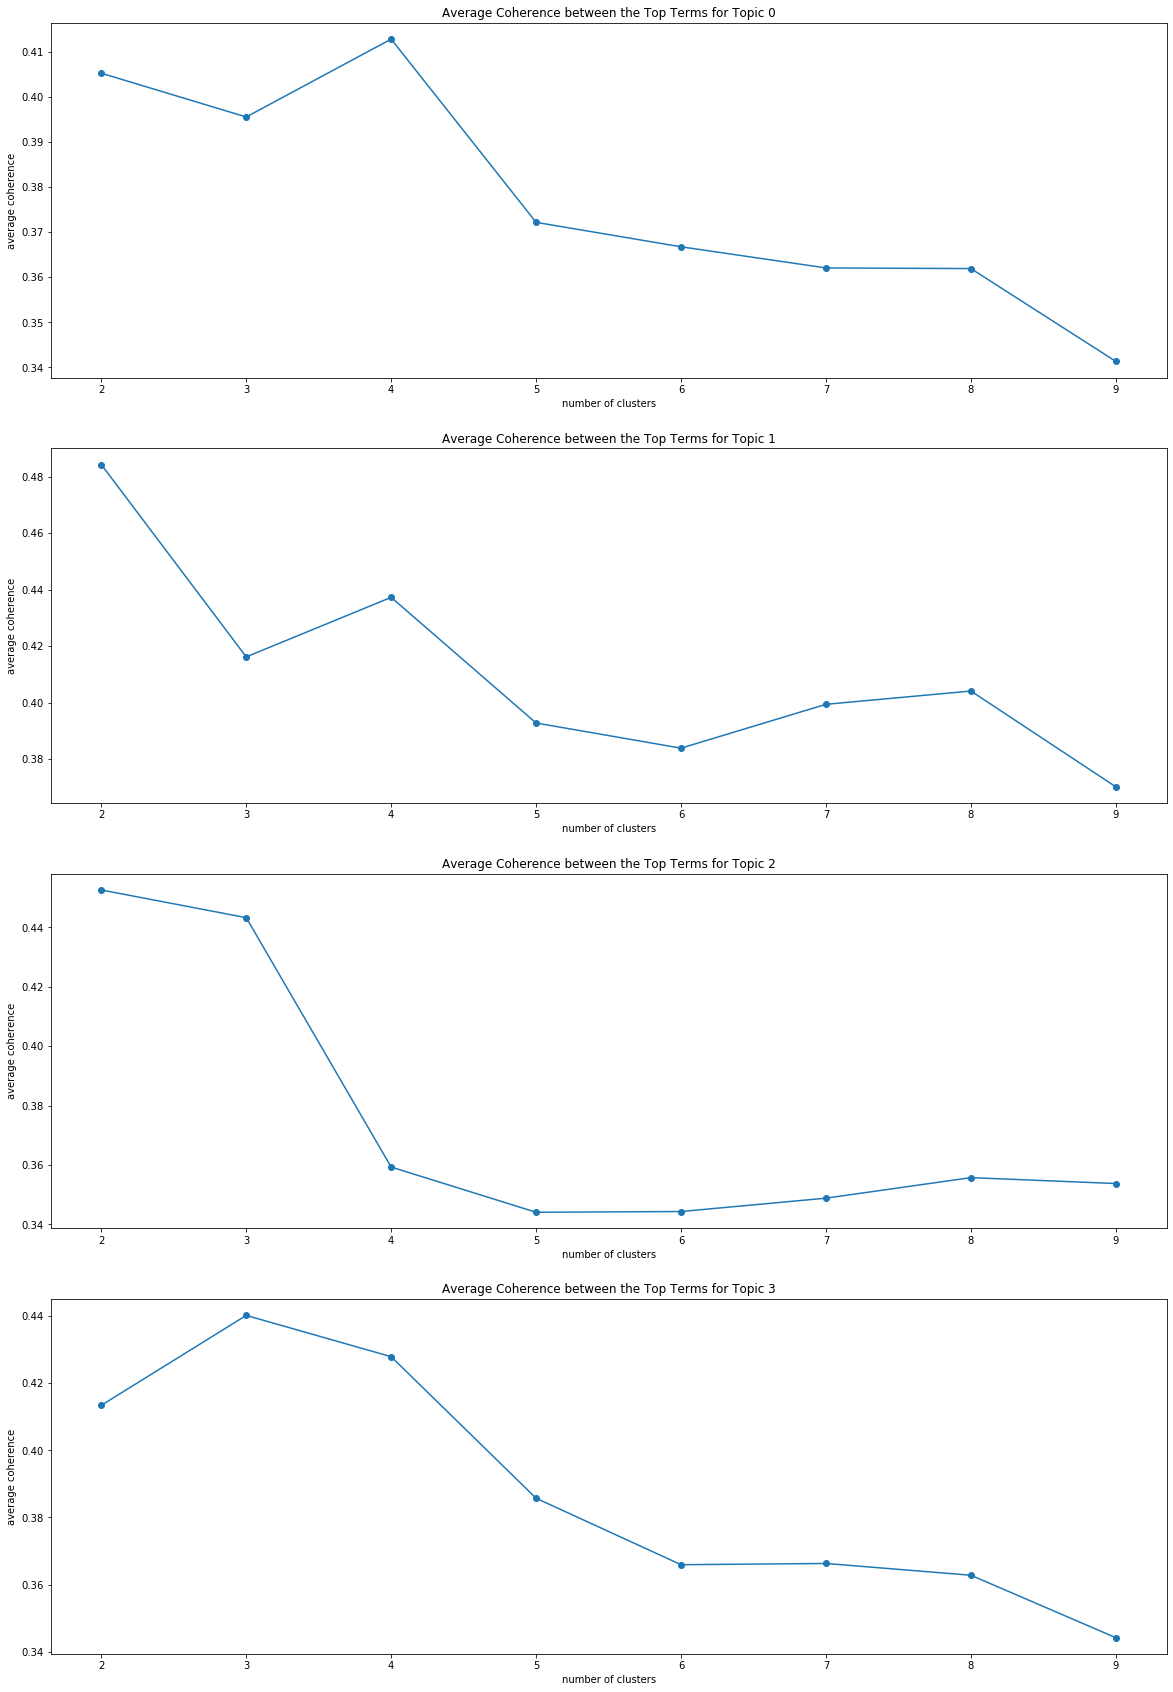

In [30]:
# number from the first level
n_topics = 4

# extract the top terms with the best number of topics in each second level
all_top_terms = []

# record the models use to create interactive visualization 
best_models = []

# creating the plot
fig, axs = plt.subplots(n_topics,1, figsize=(20,30))

# for each topic in the first level, transform and train a LDA model to get the top terms for the second level
for n in range(n_topics):
  df = job_df[job_df['LDA_cluster']==n]
  tf_docs= tf_vectorizer.fit_transform(df.cleaned_jd)
  tf_terms = tf_vectorizer.get_feature_names()  

# plot the average coherence score for different number of topics
  topics = range(2,10,1)
  topic_terms = []
  models = []
  coh_scores = []
  for t in tqdm(topics): 
    model = tm.train_model(tf_docs, t, 'LDA',RANDOM_SEED)
    top_terms = tm.get_top_terms(model, tf_terms, 10, display=False)
    mean_coherence, _ = tm.eval_topic_model(top_terms, embeddings_dict, display=False)
    coh_scores.append(mean_coherence)
    topic_terms.append(top_terms)
    models.append(model)
  
  best_n = np.argmax(coh_scores)
  all_top_terms.append(topic_terms[best_n])
  best_models.append(models[best_n])

  # let's create a simple line plot 
  axs[n].plot(topics, coh_scores, marker='o')
  axs[n].set_xticks(topics)
  axs[n].set_xticklabels(topics)
  axs[n].set_title('Average Coherence between the Top Terms for Topic {}'.format(n))
  axs[n].set_ylabel('average coherence')
  axs[n].set_xlabel('number of clusters')


In [31]:
# let's look at the top terms for each second level
L1_topics = 4
for T in range(L1_topics):
  print("Second Level Topics for First Level Topic {}:".format(T))
  for topic_idx, terms in enumerate(all_top_terms[T]):
    print("topic %d:" %(topic_idx), terms)
  print()

Second Level Topics for First Level Topic 0:
topic 0: ['hadoop', 'environment', 'google', 'predictive', 'senior', 'whats', 'code', 'optimization', 'production', 'platform']
topic 1: ['software', 'development', 'design', 'systems', 'technologies', 'cloud', 'technology', 'applications', 'engineer', 'business']
topic 2: ['insurance', 'health', 'business', 'development', 'management', 'life', 'design', 'program', 'education', 'medical']
topic 3: ['equipment', 'environment', 'service', 'safety', 'functions', 'management', 'able', 'procedures', 'maintain', 'physical']

Second Level Topics for First Level Topic 1:
topic 0: ['management', 'health', 'development', 'tools', 'systems', 'care', 'process', 'quality', 'healthcare', 'performance']
topic 1: ['development', 'product', 'tools', 'design', 'management', 'technology', 'systems', 'environment', 'software', 'technologies']

Second Level Topics for First Level Topic 2:
topic 0: ['business', 'technology', 'tools', 'development', 'product', 'so

In [32]:
# This is a interactive visualization 
warnings.filterwarnings("ignore", category=DeprecationWarning) 
pyLDAvis.enable_notebook()
df = job_df[job_df['LDA_cluster']==0]
tf_docs= tf_vectorizer.fit_transform(df.cleaned_jd)
panel = pyLDAvis.sklearn.prepare(best_models[0], tf_docs, tf_vectorizer, mds='tsne', sort_topics=False)
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      269.562408 -124.803398       1        1   5.768001
1        1.782994 -295.079681       2        1  45.824513
2      220.811432 -343.832123       3        1  30.109115
3       50.533993  -76.050934       4        1  18.298371, topic_info=     Category         Freq         Term        Total  loglift  logprob
3331  Default  5115.000000    insurance  5115.000000  30.0000  30.0000
2237  Default  5704.000000  environment  5704.000000  29.0000  29.0000
2263  Default  2142.000000    equipment  2142.000000  28.0000  28.0000
1011  Default  3178.000000         code  3178.000000  27.0000  27.0000
2894  Default  1099.000000       hadoop  1099.000000  26.0000  26.0000
...       ...          ...          ...          ...      ...      ...
6304   Topic4   727.116447       system  3580.957759   0.1041  -5.7397
6317   Topic4   820.181541      systems  7476.910698  -0.5117  -5.6193
2043   Topic4   654.288547    education  2922.840041   0.2016  -5.8452
4039   Topic4   508.212846       middot  1048.587139   0.9741  -6.0979
5445   Topic4   534.228931  responsible  2061.460261   0.3480  -6.0480

[341 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
4         1  0.008413            able
4         2  0.325708            able
4         3  0.245183            able
4         4  0.420656            able
44        2  0.117153  accommodations
...     ...       ...             ...
6994      3  0.008028           whats
7042      1  0.996225      word going
7047      3  0.034366          worker
7047      4  0.962245          worker
7079      1  0.994408         writers

[634 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

In [33]:
# This is a interactive visualization 
warnings.filterwarnings("ignore", category=DeprecationWarning) 
pyLDAvis.enable_notebook()
df = job_df[job_df['LDA_cluster']==1]
tf_docs= tf_vectorizer.fit_transform(df.cleaned_jd)
panel = pyLDAvis.sklearn.prepare(best_models[1], tf_docs, tf_vectorizer, mds='tsne', sort_topics=False)
panel

PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
0     -60.312317  141.369629       1        1  36.027416
1      60.312561 -141.369141       2        1  63.972584, topic_info=     Category         Freq        Term        Total  loglift  logprob
4280  Default  4758.000000      health  4758.000000  30.0000  30.0000
1254  Default  2989.000000        care  2989.000000  29.0000  29.0000
1489  Default  2291.000000    clinical  2291.000000  28.0000  28.0000
4301  Default  2889.000000  healthcare  2889.000000  27.0000  27.0000
7116  Default  8028.000000     product  8028.000000  26.0000  26.0000
...       ...          ...         ...          ...      ...      ...
9896   Topic2  3071.118870      within  5079.675852  -0.0565  -6.0884
7079   Topic2  3151.350980     process  5792.538698  -0.1620  -6.0626
6935   Topic2  3015.381519  predictive  5249.661026  -0.1077  -6.1067
2648   Topic2  2835.581758  developing  3951.588135   0.1148  -6.1682
7392   Topic2  2862.105881     quality  5388.224412  -0.1859  -6.1589

[214 rows x 6 columns], token_table=      Topic      Freq                  Term
term                                       
154       1  0.998647                 acute
154       2  0.003592                 acute
205       1  0.983047        administrative
205       2  0.018760        administrative
227       1  0.001819           advertising
...     ...       ...                   ...
9896      2  0.604566                within
9922      1  0.861632                  word
9922      2  0.137979                  word
9940      1  0.997399  workplace candidates
9940      2  0.006008  workplace candidates

[332 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [34]:
# This is a interactive visualization 
warnings.filterwarnings("ignore", category=DeprecationWarning) 
pyLDAvis.enable_notebook()
df = job_df[job_df['LDA_cluster']==2]
tf_docs= tf_vectorizer.fit_transform(df.cleaned_jd)
panel = pyLDAvis.sklearn.prepare(best_models[2], tf_docs, tf_vectorizer, mds='tsne', sort_topics=False)
panel

PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
0     -60.312317  141.369629       1        1  47.809407
1      60.312561 -141.369141       2        1  52.190593, topic_info=     Category         Freq         Term        Total  loglift  logprob
1229  Default  2157.000000    education  2157.000000  30.0000  30.0000
1004  Default   985.000000   department   985.000000  29.0000  29.0000
605   Default  1013.000000        cloud  1013.000000  28.0000  28.0000
3402  Default  1368.000000      service  1368.000000  27.0000  27.0000
3751  Default  1904.000000   technology  1904.000000  26.0000  26.0000
...       ...          ...          ...          ...      ...      ...
2937   Topic2   751.524360  programming  1194.686631   0.1867  -5.9088
4098   Topic2   725.742673       within  1122.255841   0.2144  -5.9437
3479   Topic2   822.338982     software  1848.511078  -0.1597  -5.8187
437    Topic2   873.927005     business  2895.211339  -0.5475  -5.7579
471    Topic2   709.287848   candidates  1270.078215   0.0677  -5.9666

[190 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
37        1  0.035990         accredited
37        2  0.963260         accredited
70        1  0.104460         additional
70        2  0.895900         additional
118       1  0.978291              agile
...     ...       ...                ...
4124      1  0.992668  worldwide deliver
4140      1  0.998267              youll
4140      2  0.001935              youll
4143      1  0.990679              youre
4143      2  0.010356              youre

[289 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [35]:
# This is a interactive visualization 
warnings.filterwarnings("ignore", category=DeprecationWarning) 
pyLDAvis.enable_notebook()
df = job_df[job_df['LDA_cluster']==3]
tf_docs= tf_vectorizer.fit_transform(df.cleaned_jd)
panel = pyLDAvis.sklearn.prepare(best_models[3], tf_docs, tf_vectorizer, mds='tsne', sort_topics=False)
panel

PreparedData(topic_coordinates=                 x            y  topics  cluster       Freq
topic                                                      
0     -1015.700562  1338.981201       1        1  62.942628
1      -387.996002  -373.316162       2        1  14.740571
2     -2184.745605   -60.565800       3        1  22.316800, topic_info=     Category         Freq          Term        Total  loglift  logprob
1619  Default  2470.000000     financial  2470.000000  30.0000  30.0000
4016  Default  3102.000000         tools  3102.000000  29.0000  29.0000
419   Default  7585.000000      business  7585.000000  28.0000  28.0000
317   Default   996.000000       banking   996.000000  27.0000  27.0000
2419  Default  2911.000000    management  2911.000000  26.0000  26.0000
...       ...          ...           ...          ...      ...      ...
200    Topic3   331.384732  architecture   769.638291   0.6572  -6.0150
2076   Topic3   359.924332    innovative  1267.228019   0.2411  -5.9324
2281   Topic3   343.208980       leading  1377.219179   0.1103  -5.9800
986    Topic3   320.078431       culture   755.755433   0.6407  -6.0498
3226   Topic3   319.830769       quality   905.631250   0.4590  -6.0505

[263 rows x 6 columns], token_table=      Topic      Freq                      Term
term                                           
7         2  0.992472         academic programs
11        1  0.132803                 accenture
11        3  0.866715                 accenture
14        1  0.998558             accommodation
24        3  0.997291  accommodations employees
...     ...       ...                       ...
4312      1  0.819790                    within
4312      2  0.018551                    within
4312      3  0.161661                    within
4316      1  0.998618                     women
4324      3  0.997138        workforce directly

[426 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])